# Circadian Vitals plotter (partial)

Description: this notebook aims to provide a data-agnostic dashboard for periodic data, with support for big data. The end goal is to enable easy visualization of any kind of periodic data, ranging from sleep diaries, ECG, temperature, etc. The focus is on longitudinal data of a single subject, not on group data.

This notebook plots core body temperature, wrist skin temperature and the sleep diary, but not ECG nor actigraphy. This is to draft code faster, because ECG and actigraphy are big data and require to build databases which is time consuming, although the code is ready (see parquet loader in circalizer.ipynb).

Current state: loading core temp (pre-extracted from cloud) works.

How to install dependencies:
* download Miniconda 3
* select option to add Python to path
* open Miniconda prompt
* type the following:
    * `conda install python=3.10`
    * `conda install pandas dask`
    * `conda install -c pyviz holoviews bokeh`
    * `conda install jupyter hvplot fastparquet datashader`
    * Datashader >= v0.14.2 is required, otherwise a [Division By Zero error will happen on plotting due to a bug in the antialiasing function](https://github.com/holoviz/datashader/issues/989). As of August 2022, the patch is not yet in the latest main release, instead update with the following command: `conda install -c pyviz/label/dev datashader`
* launch using `jupyter notebook` in a command prompt

Future steps:
* Consolidate loading and visualizing code in neat, generalizable functions to plot any input big data.
* Consolidate multiple vitals visualizations into one synchronized (in the time axis) visualization.
* Make a dashboard with Panel and allow file upload, to deploy on heroku for easy use for small datasets (but for big datasets, local use will be mandatory since file uploads cannot cope with huge datasets).

## General initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Generate figure inside IPython Notebook (must be called before any import of matplotlib, direct or indirect!)
%matplotlib inline

import matplotlib.pyplot as plt

In [6]:
import pandas as pd
#import vaex
import dask.dataframe as dd
import hvplot.pandas  # noqa
import hvplot.dask  # noqa
#import fastparquet

#import multiprocessing as mp

import glob
import os

# Local aux scripts
# If there is an issue with Visual Studio Code's PyLance not finding the library, try to hit CTRL+SHIFT+P and type "Python: Select Interpreter" and select the one you want to use, or type "Python: Clear Cache" https://stackoverflow.com/a/74177108/1121352
from lib.fix_ibuttons_csv import fix_ibuttons_csv

## Aux funcs

In [7]:
def dask_load_csv_dir_inmemory(inputdir, inputglob, preprocess_callback=None, postprocess_callback=None, blocksize="1GB", csvdelimiter=',', **kwargs):
    '''Lazily load a set of csv files using dask.
    preprocess_callback will be called on the input filenames list and needs to return a dict with at least one item with key 'outfileslist' and value being a list of filenames or a list of file-like objects, eg, {'outfileslist': list(filename1, filename2, etc)}. Then, other items of the returned dict will be supplied as arguments to dask csv or parquet reader.
    postprocess_callback will be called on the dataframe after loading data.
    kwargs arguments will be passed onto dask.read_csv().'''
    # Fetch list of input files matching the glob pattern
    infiles = glob.glob(inputdir+inputglob)
    # Keep only the filename (not the fullpath)
    infilenames = [os.path.basename(path) for path in infiles]
    # List of absolute paths
    infileslist = list([inputdir+f for f in infilenames])
    
    # Pre-process the input files beforehand, this is useful to fix malformatted csv files for example or extract the number of rows to skip for each file
    if preprocess_callback is not None:
        preproc_return = preprocess_callback(infileslist)
        # Get list of filepaths or files-like objects
        infileslist = preproc_return.pop('outfileslist')
        # Get other arguments if any to supply to dask reader
        kwargs = dict(kwargs, **preproc_return)  # alternative in Python 3.9: kwargs = kwargs | preproc_return

    # Read only the new csv files, in chunks of blocksize so that we can load larger-than-ram csv files
    df = dd.read_csv(infileslist, blocksize=blocksize, sep=csvdelimiter, **kwargs)

    # Post-process the new database (set index etc) given the user's function
    if postprocess_callback is not None:
        df = postprocess_callback(df)

    # Return the dask dataframe
    return df

def dask_load_csv_dir_to_parquet(inputdir, inputglob, outdb, indexpath, preprocess_callback=None, postprocess_callback=None, blocksize="1GB", csvdelimiter=',', force_rebuild=False, **kwargs):
    '''Lazily and incrementally load a set of csv files and convert to parquet using dask.
    Why use parquet files when CSV files can be directly loaded? Because they are optimized for near constant time random access, hence perfect for big data visualization, whereas CSV files can only allow at best a linear time for random access to any record.
    Only new csv files will be incrementally inserted into the parquet database, except if force_rebuild=True.
    outdb is a folder where the parquet files will be stored.
    indexpath is the location of the index file to log which csv files were already processed and provide incremental building.
    preprocess_callback will be called on the input filenames list and needs to return a list of filenames.
    postprocess_callback will be called on the dataframe after loading data.
    kwargs arguments will be passed onto dask.read_csv().'''
    # Fetch list of input files matching the glob pattern
    infiles = glob.glob(inputdir+inputglob)
    # Keep only the filename (not the fullpath)
    infilenames = [os.path.basename(path) for path in infiles]
    # Get the list of already processed filenames so that we can incrementally build on top (instead of reprocessing the whole database each time)
    if os.path.exists(indexpath) and not force_rebuild:
        with open(indexpath, mode='rt', encoding='utf-8') as indexfile:
            indexfilenames = set(indexfile.read().splitlines())  # readlines() appends a \n character at the end of each line...
    else:
        indexfilenames = set()
        force_rebuild = True # no index file, we should rebuild from scratch the whole db
    # Exclude already processed input files, so we process only new files
    newinfiles = list(set(infilenames).difference(indexfilenames))

    # Check if is no new input files, then return the database
    if not newinfiles:
        if os.path.exists(outdb):
            return dd.read_parquet(outdb, engine='fastparquet')
        else:
            # If no input files nor database found, then it's an error!
            raise ValueError('No input file nor database found!')

    # List of absolute paths
    newinfileslist = list([inputdir+f for f in newinfiles])
    
    # Pre-process the input files beforehand, this is useful to fix malformatted csv files for example
    if preprocess_callback is not None:
        preproc_return = preprocess_callback(newinfileslist)
        # Get list of filepaths or files-like objects
        newinfileslist = preproc_return.pop('outfileslist')
        # Get other arguments if any to supply to dask reader
        kwargs = dict(kwargs, **preproc_return)  # alternative in Python 3.9: kwargs = kwargs | preproc_return
            
    # Read only the new csv files, in chunks of blocksize so that we can load larger-than-ram csv files
    df = dd.read_csv(newinfileslist, blocksize=blocksize, sep=csvdelimiter, **kwargs)

    # Post-process the new database (set index etc) given the user's function
    if postprocess_callback is not None:
        df = postprocess_callback(df)

    # Reload previous parquet database to incrementally update it with data from new csv files
    if os.path.exists(outdb):
        dfprev = dd.read_parquet(outdb, engine='fastparquet')
        # Lazily concat
        dfconcat = dd.concat([dfprev, df])
    else:
        dfconcat = df
    # Convert the multi-files CSV dataset to a parquet, for random access memory-mapped faster access and interactivity with datashader plotting
    df.to_parquet(outdb) # compression='snappy'  # if generated parquet file is too big, maybe try write_index=False https://stackoverflow.com/questions/68688309/why-does-dask-seem-to-store-parquet-inefficiently
    # Reload dataframe from parquet (faster random access than from CSV files)
    df = dd.read_parquet(outdb, engine='fastparquet')  # use pure-python fastparquet implementation
    # Although it's possible to put everything inside a single parquet file, there are advantages to keep multiple partitions: https://stackoverflow.com/questions/61759297/dask-dataframe-concatenating-parquet-files-throws-out-of-memory

    # Update the index file to add the newly processed files (and hence skip them next time)
    if newinfiles:
        with open(indexpath, mode='at' if not force_rebuild else 'wt', encoding='utf-8') as indexfile:
            indexfile.write('\n'.join(newinfiles))

    # Return the dask dataframe
    return df

def dask_load_csv_dir_auto(inputdir, inputglob, modality, *args, maxdirsize=10**8, **kwargs):
    '''Lazily load a set of csv files using dask, directly as csv (in-memory) if below a max total dirsize or use parquet to build an out-of-memory database otherwise.
    Default is 100MB, if all the CSV files are beyond this maxdirsize, we load in parquet.
    Modality is the name you want to give this modality, this will be used to define path to the parquet database files.
    kwargs arguments will be passed onto dask.read_csv().'''
    # Fetch list of input files matching the glob pattern
    infiles = glob.glob(inputdir+inputglob)
    # Keep only the filename (not the fullpath)
    infilenames = [os.path.basename(path) for path in infiles]
    # Absolute paths to files
    infileslist = list([inputdir+f for f in infilenames])
    # Check dir size (walk on each file to get size)
    if sum(os.stat(f).st_size for f in infileslist) <= maxdirsize:
        # Smaller than maxdirsize, we directly read all the CSV in-memory (linear access time)
        return dask_load_csv_dir_inmemory(inputdir, inputglob, *args, **kwargs)
    else:
        # Bigger than maxdirsize, we create an out-of-memory parquet database (constant access time, whatever the database size)
        return dask_load_csv_dir_to_parquet(inputdir, inputglob, modality, "%s/%s_index.txt" % (modality, modality), *args, **kwargs)


## Loading data

### Core temperature (from cloud)

In [8]:
def postprocess_coretemp(dft):
    # Rename columns for easier access
    dft = dft.rename(columns={'DateTime': 'datetime', 'CoreBodyTemp [C]': 'cbt', 'TempChangeRate [C/h]': 'cbt_changerate', 'SkinTemp [C]': 'skintemp'})
    dft.columns = dft.columns.to_series().replace({'TempQuality.*': 'quality'}, regex=True) # With regular expression for dynamic or too long string, see : https://stackoverflow.com/questions/46706850/pandas-rename-columns-with-wildcard
    # Convert datetime string or timestamp to a datetime type column to plot more easily the timeseries
    #dft['timestamp'] = dd.to_datetime(dft['timestamp'], unit='ns')
    dft['datetime'] = dd.to_datetime(dft['datetime'], format="%d.%m.%Y %H:%M:%S", exact=False)
    # set datetime as index
    dft = dft.set_index('datetime')
    return dft

inputdir = r'../data/coretemp/'
inputglob = r'*.csv'
df_tc = dask_load_csv_dir_auto(inputdir, inputglob, 'CoreTemp', postprocess_callback=postprocess_coretemp, csvdelimiter=';', skiprows=1, assume_missing=True)
df_tc.head()

cbt  cbt_changerate  quality  skintemp
datetime                                                     
2021-02-04 01:34:12  37.07             NaN      1.0     30.81
2021-02-04 01:39:12  37.35            3.31      2.0     33.96
2021-02-04 01:44:12  37.37            0.31      3.0     35.42
2021-02-04 01:49:12  37.39            0.19      4.0     36.15
2021-02-04 01:54:12  37.43            0.48      4.0     36.46

In [36]:
from holoviews.operation.datashader import datashade, dynspread
#df_tc['cbt'].hvplot.line(datashade=True).options(ylim=(df_tc['cbt'].quantile(0.01).compute(), df_tc['cbt'].max().compute()))
# TODO: Color lines depending on df_tc['quality'] (beware there are NA values) - Cannot do that with Bokeh, the underlying JS library does not support coloring lines or curves with varying colors
# Alternatives: background highlight https://towardsdatascience.com/how-to-add-gradient-background-to-python-plots-9beda811ea19 , https://stackoverflow.com/questions/55698789/how-do-i-assign-multiple-colors-to-the-x-axis-in-bokeh
# Alternative: https://holoviews.org/user_guide/Style_Mapping.html#custom-color-intervals
# Normally, Nan values won't be plotted, these will be considered as gaps as they should be: https://stackoverflow.com/questions/29000725/bokeh-plotting-data-with-gaps
#cline = df_tc.hvplot.line(x='datetime', y='cbt', datashade=True).options(ylim=(df_tc['cbt'].quantile(0.01).compute(), df_tc['cbt'].max().compute()))
cline = df_tc.hvplot.line(x='datetime', y='cbt', by='quality').options(ylim=(df_tc['cbt'].quantile(0.01).compute(), df_tc['cbt'].max().compute()))
#cline.opts(bgcolor=df_tc['quality'].apply(lambda x: 'red' if x == 0.0 else 'orange' if x == 1.0 else 'yellow' if x == 2.0 else 'green' if x == 4.0 else 'blue', meta=('quality', 'object')))
cline
#cline + dynspread(datashade(cline, height=1200, width=1200, dynamic=False, \
#                            cmap=["#30a2da"]), max_px=3, threshold=1)


:NdOverlay   [quality]
   :Curve   [datetime]   (cbt)

### Wrist skin temperature

In [37]:
def skiprows_search(infileslist, pattern=','):
    # read each csv file to check when the csv data starts and how many rows to skip (to provide the info to dask reader)
    skiprows_list = []
    for f in infileslist:
        found = False
        with open(f, 'r') as fh:
            for (i, line) in enumerate(fh.readlines()):
                # Very simple detection: we simply walk through each line until we find one with a comma, and we consider this to be the start of the csv table
                if pattern in line:
                    found = True
                    skiprows_list.append(i)  # should be i-1 if i started at 1 because we want to stop skipping rows before the current one which is the table's header, but since it's 0 indexed in Python, we don't need to
                    break
        if not found:
                skiprows_list.append(0)
    return skiprows_list

def preprocess_wristtemp(infileslist):
    # fix invalid csv formatting of ibuttons csv files as generated by the OneWireViewer app
    outfileslist = [fix_ibuttons_csv(f) for f in infileslist]
    # read each csv file to check when the csv data starts and how many rows to skip (to provide the info to dask reader)
    skiprows_list = skiprows_search(outfileslist, pattern=',')
    #print(list(zip(outfileslist,skiprows_list)))
    #print(set(skiprows_list))
    if len(set(skiprows_list)) > 1:
        raise(Exception('Input files have varying number of rows to skip before the table starts, pandas and dask do not support that, please fix input files to all start after the same number of rows.'))
    return {'outfileslist': outfileslist, 'skiprows': skiprows_list[0]}

def postprocess_wristtemp(dfti):
    # Rename columns
    dfti = dfti.rename(columns={'Date/Time': 'datetime', 'Unit': 'unit', 'Value': 'temperature'})
    # Convert datetime string or timestamp to a datetime type column to plot more easily the timeseries
    #dfti['timestamp'] = dd.to_datetime(dfti['timestamp'], unit='ns')
    dfti['datetime'] = dd.to_datetime(dfti['datetime'], format="%d/%m/%y %H:%M:%S", exact=False)  # exact=False allows for partial match of datetime string formatting, the rest after is ignored (and it's faster than manual strings preprocessing)
    # set timestamp as index
    dfti = dfti.set_index('datetime')
    # drop duplicates
    dfti = dfti.drop_duplicates()
    return dfti

inputdir = r'../data/wristtemp/'
inputglob = r'*.csv'
df_tw = dask_load_csv_dir_auto(inputdir, inputglob, 'WristTemp', preprocess_callback=preprocess_wristtemp, postprocess_callback=postprocess_wristtemp, csvdelimiter=',', assume_missing=True)
df_tw.head()

unit  temperature
datetime                             
2020-11-30 17:58:12    C       18.688
2020-11-30 18:03:12    C       20.375
2020-11-30 18:08:12    C       20.750
2020-11-30 18:13:12    C       20.625
2020-11-30 18:23:12    C       20.812

In [38]:
print(df_tw.tail())

                    unit  temperature
datetime                             
2022-06-27 14:24:26    C       39.750
2022-06-27 14:44:26    C       39.000
2022-06-27 14:54:26    C       39.062
2022-06-27 15:19:26    C       38.875
2022-06-27 16:39:26    C       38.562


In [39]:
df_tw['temperature'].hvplot.line(datashade=True).options(ylim=(df_tw['temperature'].min().compute(), df_tw['temperature'].max().compute()))

:DynamicMap   []
   :RGB   [datetime,temperature]   (R,G,B,A)

In [ ]:
# TODO: implement csv delimiter and header sniffer? https://stackoverflow.com/a/26599892/1121352 and https://docs.python.org/3/library/csv.html#csv.Sniffer


### Sleep diary

In [40]:
def preprocess_sleepmeter(infileslist):
    # read each csv file to check when the csv data starts and how many rows to skip (to provide the info to dask reader)
    skiprows_list = skiprows_search(infileslist, pattern='wake,sleep,bedtime,holes,type,dreams,aid,hindrances,tags,quality,notes')
    if len(set(skiprows_list)) > 1:
        raise(Exception('Input files have varying number of rows to skip before the table starts, pandas and dask do not support that, please fix input files to all start after the same number of rows.'))
    return {'outfileslist': infileslist, 'skiprows': skiprows_list[0]}

def postprocess_sleepmeter(dfti):
    #TODO: expand holes into their own records
    # Convert datetime string or timestamp to a datetime type column to plot more easily the timeseries
    dfti['wake'] = dd.to_datetime(dfti['wake'], format="%y-%m-%d %H:%M%z", exact=False)  # exact=False allows for partial match of datetime string formatting, the rest after is ignored (and it's faster than manual strings preprocessing)
    dfti['sleep'] = dd.to_datetime(dfti['sleep'], format="%y-%m-%d %H:%M%z", exact=False)
    # set timestamp as index
    #dfti = dfti.set_index('datetime')
    return dfti

inputdir = r'../data/sleep-diary/'
inputglob = r'*.csv'
df_sm = dask_load_csv_dir_auto(inputdir, inputglob, 'SleepDiary', preprocess_callback=preprocess_sleepmeter, postprocess_callback=postprocess_sleepmeter, csvdelimiter=',', assume_missing=True)
df_sm.head()

wake                      sleep  \
0  2022-08-04 09:40:00+02:00  2022-08-04 04:35:00+02:00   
1  2022-08-03 20:48:00+02:00  2022-08-03 18:47:00+02:00   
2  2022-08-03 08:48:00+02:00  2022-08-03 01:27:00+02:00   
3  2022-08-02 21:42:00+02:00  2022-08-02 17:53:00+02:00   
4  2022-08-02 09:30:00+02:00  2022-08-02 02:28:00+02:00   

                 bedtime                  holes         type        dreams  \
0  2022-08-04 04:20+0200                178-210  NIGHT_SLEEP          NONE   
1  2022-08-03 18:32+0200                  38-68  NIGHT_SLEEP          NONE   
2  2022-08-03 01:12+0200  93-98|108-243|310-398  NIGHT_SLEEP          NONE   
3  2022-08-02 17:38+0200          49-59|169-179  NIGHT_SLEEP          NONE   
4  2022-08-02 02:13+0200  17-47|111-174|217-225  NIGHT_SLEEP  TROUBLING:-2   

                                                 aid  \
0  CUSTOM_0032|CUSTOM_0013|CUSTOM_0014|CUSTOM_002...   
1  CUSTOM_0032|CUSTOM_0011|CUSTOM_0013|CUSTOM_001...   
2    CUSTOM_0014|CUSTOM_0022|CUSTOM_0024|CUSTOM_0027   
3  CUSTOM_0032|CUSTOM_0013|CUSTOM_0014|CUSTOM_002...   
4  CUSTOM_0032|CUSTOM_0013|CUSTOM_0014|CUSTOM_003...   

                                          hindrances  \
0  CUSTOM_0082|CUSTOM_0014|CUSTOM_0054|CUSTOM_005...   
1    CUSTOM_0031|CUSTOM_0042|CUSTOM_0047|CUSTOM_0079   
2  CUSTOM_0004|CUSTOM_0086|CUSTOM_0082|CUSTOM_006...   
3    CUSTOM_0086|CUSTOM_0068|CUSTOM_0017|CUSTOM_0047   
4  CUSTOM_0004|CUSTOM_0082|CUSTOM_0017|CUSTOM_005...   

                                                tags  quality  \
0                CUSTOM_0057|CUSTOM_0072|CUSTOM_0039      5.0   
1    CUSTOM_0009|CUSTOM_0022|CUSTOM_0072|CUSTOM_0039      5.0   
2  COUCH|CUSTOM_0066|CUSTOM_0072|CUSTOM_0039|CUST...      5.0   
3  CUSTOM_0009|CUSTOM_0022|CUSTOM_0072|CUSTOM_003...      5.0   
4  CUSTOM_0009|CUSTOM_0022|CUSTOM_0039|CUSTOM_005...      5.0   

               notes  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4  Stopped nicotine

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
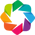

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\THEMATRIXNEO\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\THEMATRIXNEO\AppData\Local\Temp\ipykernel_3332\2056749226.py", line 6, in <module>
    hv.Segments(df_sm.loc[1:10, ['sleep', 'wake']])
  File "c:\Users\THEMATRIXNEO\miniconda3\lib\site-packages\holoviews\element\selection.py", line 23, in __init__
    super().__init__(*args, **kwargs)
  File "c:\Users\THEMATRIXNEO\miniconda3\lib\site-packages\holoviews\core\data\__init__.py", line 341, in __init__
    super(Dataset, self).__init__(data, **dict(kwargs, **dict(dims, **extra_kws)))
  File "c:\Users\THEMATRIXNEO\miniconda3\lib\site-packages\holoviews\core\dimension.py", line 844, in __init__
    super().__init__(data, **params)
  File "c:\Users\THEMATRIXNEO\miniconda3\lib\site-packages\holoviews\core\dimension.py", line 503, in __init__
    super().__init__(**params)
  F

In [41]:
import numpy as np
import holoviews as hv
from holoviews import dim
hv.extension('bokeh')

hv.Segments(df_sm.loc[1:10, ['sleep', 'wake']])


In [110]:
df_sm.head()

wake                      sleep  \
0  2022-08-04 09:40:00+02:00  2022-08-04 04:35:00+02:00   
1  2022-08-03 20:48:00+02:00  2022-08-03 18:47:00+02:00   
2  2022-08-03 08:48:00+02:00  2022-08-03 01:27:00+02:00   
3  2022-08-02 21:42:00+02:00  2022-08-02 17:53:00+02:00   
4  2022-08-02 09:30:00+02:00  2022-08-02 02:28:00+02:00   

                 bedtime                  holes         type        dreams  \
0  2022-08-04 04:20+0200                178-210  NIGHT_SLEEP          NONE   
1  2022-08-03 18:32+0200                  38-68  NIGHT_SLEEP          NONE   
2  2022-08-03 01:12+0200  93-98|108-243|310-398  NIGHT_SLEEP          NONE   
3  2022-08-02 17:38+0200          49-59|169-179  NIGHT_SLEEP          NONE   
4  2022-08-02 02:13+0200  17-47|111-174|217-225  NIGHT_SLEEP  TROUBLING:-2   

                                                 aid  \
0  CUSTOM_0032|CUSTOM_0013|CUSTOM_0014|CUSTOM_002...   
1  CUSTOM_0032|CUSTOM_0011|CUSTOM_0013|CUSTOM_001...   
2    CUSTOM_0014|CUSTOM_0022|CUSTOM_0024|CUSTOM_0027   
3  CUSTOM_0032|CUSTOM_0013|CUSTOM_0014|CUSTOM_002...   
4  CUSTOM_0032|CUSTOM_0013|CUSTOM_0014|CUSTOM_003...   

                                          hindrances  \
0  CUSTOM_0082|CUSTOM_0014|CUSTOM_0054|CUSTOM_005...   
1    CUSTOM_0031|CUSTOM_0042|CUSTOM_0047|CUSTOM_0079   
2  CUSTOM_0004|CUSTOM_0086|CUSTOM_0082|CUSTOM_006...   
3    CUSTOM_0086|CUSTOM_0068|CUSTOM_0017|CUSTOM_0047   
4  CUSTOM_0004|CUSTOM_0082|CUSTOM_0017|CUSTOM_005...   

                                                tags  quality  \
0                CUSTOM_0057|CUSTOM_0072|CUSTOM_0039      5.0   
1    CUSTOM_0009|CUSTOM_0022|CUSTOM_0072|CUSTOM_0039      5.0   
2  COUCH|CUSTOM_0066|CUSTOM_0072|CUSTOM_0039|CUST...      5.0   
3  CUSTOM_0009|CUSTOM_0022|CUSTOM_0072|CUSTOM_003...      5.0   
4  CUSTOM_0009|CUSTOM_0022|CUSTOM_0039|CUSTOM_005...      5.0   

               notes  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4  Stopped nicotine

In [164]:
a = df_sm.loc[2:3, :].compute()
a['holes2'] = a['holes'].str.split('|', expand=False)
a.apply(lambda row: [y.split('-') for y in row['holes2']], axis=1, result_type='reduce')

TypeError: 'float' object is not iterable

In [166]:
# Preprocess holes into a more readable, list format

# First split each hole, separated by a pipe
df_sm['holes2'] = df_sm['holes'].str.split('|', expand=False)
# Secondly, split start and end times, separated by a dash -
df_sm['holes3'] = df_sm.apply(lambda row: [x.split('-') for x in row['holes2']] if isinstance(row['holes2'], list) else [], axis=1, result_type='reduce', meta=(None, 'object'))
# preview results
df_sm.loc[2:3, :].compute()

In [103]:
df_sm.loc[1:10, ['sleep', 'wake']].compute()

sleep                       wake
1   2022-08-03 18:47:00+02:00  2022-08-03 20:48:00+02:00
2   2022-08-03 01:27:00+02:00  2022-08-03 08:48:00+02:00
3   2022-08-02 17:53:00+02:00  2022-08-02 21:42:00+02:00
4   2022-08-02 02:28:00+02:00  2022-08-02 09:30:00+02:00
5   2022-08-01 14:20:00+02:00  2022-08-01 15:24:00+02:00
6   2022-08-01 07:21:00+02:00  2022-08-01 11:00:00+02:00
7   2022-07-31 10:20:00+02:00  2022-07-31 18:36:00+02:00
8   2022-07-31 04:50:00+02:00  2022-07-31 04:50:00+02:00
9   2022-07-30 21:53:00+02:00  2022-07-31 03:05:00+02:00
10  2022-07-30 01:47:00+02:00  2022-07-30 08:14:00+02:00

In [109]:
event = ['A', 'A']
data = dict(
    start=[np.datetime64('1999'), np.datetime64('2011')],
    end=[np.datetime64('2009'), np.datetime64('2020')],
    start_event = event,
    end_event = event
)
print(data)
seg = hv.Segments(data, [hv.Dimension('start', label='Year'), 
                         hv.Dimension('start_event', label='Event'), 'end', 'end_event'])
seg.opts(color='k', line_width=10)
seg


{'start': [numpy.datetime64('1999'), numpy.datetime64('2011')], 'end': [numpy.datetime64('2009'), numpy.datetime64('2020')], 'start_event': ['A', 'A'], 'end_event': ['A', 'A']}


:Segments   [start,start_event,end,end_event]